In [2]:
from shapely import Point, MultiPoint, Polygon, LineString, GeometryCollection, box, affinity, ops

In [3]:
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
import numpy as np
import progressbar
import colorsys
import json
import csv

In [4]:
from dimensionality_reduction import reduce_dimensions
from tree import build_tree

In [5]:
from shapely.ops import triangulate
import geopandas as gpd
import matplotlib.pyplot as plt

In [6]:
EMBEDDINGS_FILE = 'embeddings.json'
REDUCED_FILE = 'reduced_embeddings_2d.csv'

In [7]:
with open(EMBEDDINGS_FILE,'r') as infile:
    data = json.load(infile)

In [8]:
embedding_labels = list(data.keys())
labels = [l[:-3] for l in embedding_labels] # get rid of '.md' file extension

In [9]:
embeddings = np.array([data[label] for label in embedding_labels])
latent_space = reduce_dimensions(embeddings,4)

In [10]:
latent_space, color_space = latent_space[:,0:2], latent_space[:,2:4]

In [11]:
color_space = (color_space-np.min(color_space))/(np.max(color_space)-np.min(color_space))
color_space = [colorsys.hsv_to_rgb(vals[0], vals[1]/2, 0.85) for vals in color_space]

In [12]:
with open(REDUCED_FILE, 'w', newline='', encoding='utf-8') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(['x', 'y', 'filename'])
    for label, coords in zip(labels, latent_space):
        writer.writerow([coords[0], coords[1], label])

In [13]:
tree = build_tree(EMBEDDINGS_FILE)

In [14]:
total_nodes = tree.get_children()

In [15]:
def get_points(tree):
    points = np.empty((tree.get_children(),2))
    for i, filename in enumerate(tree.files):
        idx = embedding_labels.index(filename)
        points[i] = latent_space[idx]
    return points

In [16]:
def centroid(tree):
    return get_points(tree).mean(axis=0)

In [17]:
def balance(left, right):
    l_count = left.get_children()
    r_count = right.get_children()
    if l_count > r_count: comparison = 1-max(0.01, r_count/l_count)
    elif r_count > l_count: comparison = -(1-max(0.01, l_count/r_count))
    else: comparison = 0
    return comparison

In [18]:
points = MultiPoint(latent_space)

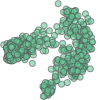

In [19]:
points

In [22]:
print(len(latent_space))

594


In [21]:
triangles = triangulate(points)

In [22]:
triangles

[<POLYGON ((-0.265 0.042, -0.249 -0.044, -0.247 -0.033, -0.265 0.042))>,
 <POLYGON ((-0.265 0.042, -0.247 -0.033, -0.249 0.021, -0.265 0.042))>,
 <POLYGON ((-0.265 0.042, -0.249 0.021, -0.249 0.023, -0.265 0.042))>,
 <POLYGON ((-0.265 0.042, -0.249 0.023, -0.246 0.026, -0.265 0.042))>,
 <POLYGON ((-0.265 0.042, -0.246 0.026, -0.244 0.05, -0.265 0.042))>,
 <POLYGON ((-0.265 0.042, -0.244 0.05, -0.201 0.07, -0.265 0.042))>,
 <POLYGON ((-0.265 0.042, -0.201 0.07, 0.069 0.295, -0.265 0.042))>,
 <POLYGON ((0.069 0.295, -0.201 0.07, -0.15 0.096, 0.069 0.295))>,
 <POLYGON ((0.069 0.295, -0.15 0.096, -0.017 0.16, 0.069 0.295))>,
 <POLYGON ((0.069 0.295, -0.017 0.16, 0.102 0.243, 0.069 0.295))>,
 <POLYGON ((0.069 0.295, 0.102 0.243, 0.119 0.262, 0.069 0.295))>,
 <POLYGON ((0.069 0.295, 0.119 0.262, 0.177 0.253, 0.069 0.295))>,
 <POLYGON ((0.069 0.295, 0.177 0.253, 0.237 0.232, 0.069 0.295))>,
 <POLYGON ((0.237 0.232, 0.177 0.253, 0.192 0.22, 0.237 0.232))>,
 <POLYGON ((0.237 0.232, 0.192 0.22, 

In [23]:
gdf = gpd.GeoDataFrame(geometry=triangles)
gdf

,geometry
0,"POLYGON ((-0.26533 0.04241, -0.24870 -0.04442,..."
1,"POLYGON ((-0.26533 0.04241, -0.24671 -0.03321,..."
2,"POLYGON ((-0.26533 0.04241, -0.24890 0.02117, ..."
3,"POLYGON ((-0.26533 0.04241, -0.24870 0.02290, ..."
4,"POLYGON ((-0.26533 0.04241, -0.24636 0.02561, ..."
...,...
1169,"POLYGON ((0.07965 -0.14331, 0.05111 -0.16114, ..."
1170,"POLYGON ((0.06071 -0.17728, 0.05111 -0.16114, ..."
1171,"POLYGON ((0.03787 -0.19436, 0.02723 -0.20743, ..."
1172,"POLYGON ((0.03585 -0.22093, 0.02723 -0.20743, ..."


In [24]:
gdf.to_file("triangles.geojson", driver="GeoJSON")

In [25]:
gdf_points = gpd.GeoDataFrame(geometry=[points])
gdf_points

,geometry
0,"MULTIPOINT (0.18072 -0.00888, 0.19377 0.01208,..."


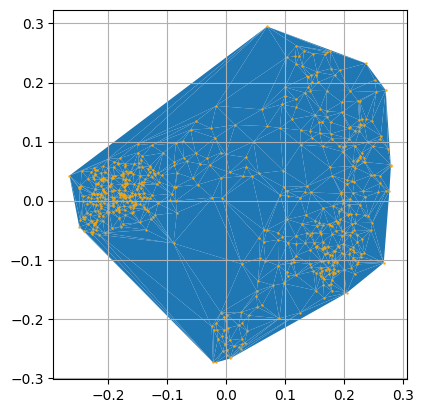

In [28]:
fig, ax = plt.subplots(1,1)

gdf.plot(ax=ax, aspect='equal')
gdf_points.plot(ax=ax, aspect='equal', color='orange', markersize = 0.5)
plt.grid()

In [27]:
bounding_box = box(*points.bounds)
bounding_box = affinity.scale(bounding_box, xfact=1.2, yfact=1.2)

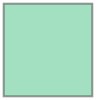

In [28]:
bounding_box